## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

Valor máximo antes de normalizar 255
Valor máximo después de normalizar 1.0
(1024, 1024, 3)


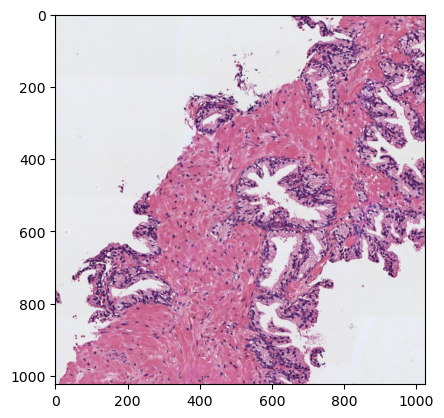

In [2]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen
import skimage.io as io
import matplotlib.pyplot as plt

image = io.imread('imgs/histo_1.jpg')

print("Valor máximo antes de normalizar",image.max())

image = image / 255

print("Valor máximo después de normalizar",image.max())

print(image.shape)

plt.imshow(image)
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

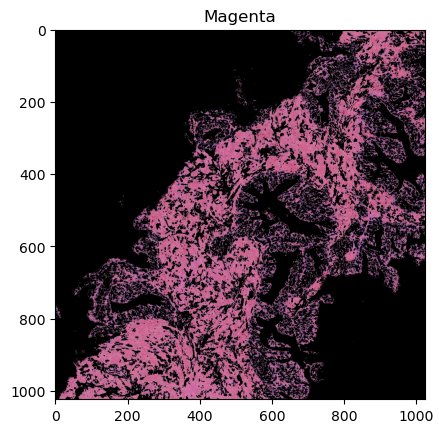

In [2]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

#Al ser RGB, el magenta es la combinación de rojo, azul y un poco de verde

rojo = image[:,:,0]
verde = image[:,:,1]
azul = image[:,:,2]

mascara = (rojo > 0.5) & (verde < 0.5) & (azul > 0.5)

magenta = image.copy()

magenta[~mascara] = 0

plt.title("Magenta")
plt.imshow(magenta, cmap='gray')
plt.show()

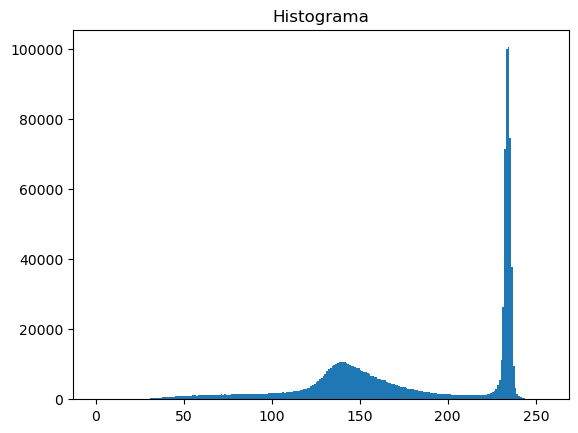

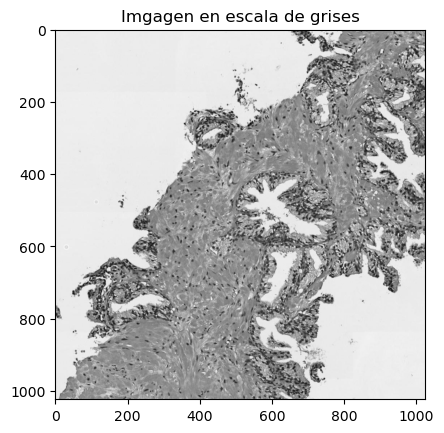

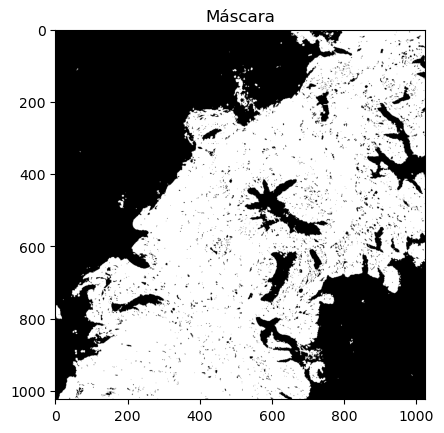

In [5]:
#Extracción directa de treshold
import cv2

image_uint8 = (image * 255).astype('uint8')

img = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)

plt.title("Histograma")
plt.hist(img.flatten(), bins=256, range=[0,256])
plt.show()

plt.title("Imgagen en escala de grises")
plt.imshow(img, cmap='gray')
plt.show()

mascara_magenta = (img > 200).astype('uint8')
mascara_magenta = ~mascara_magenta

plt.title("Máscara")
plt.imshow(mascara_magenta, cmap='gray')
plt.show()


#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

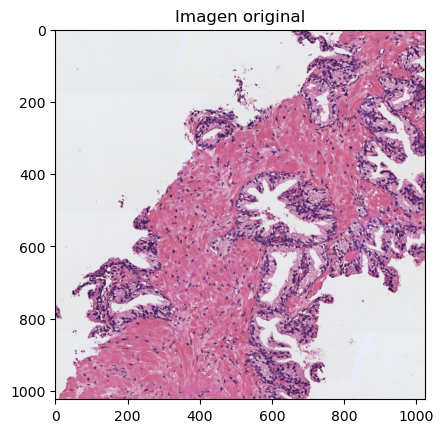

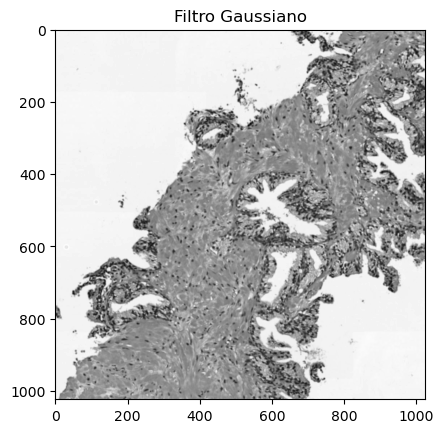

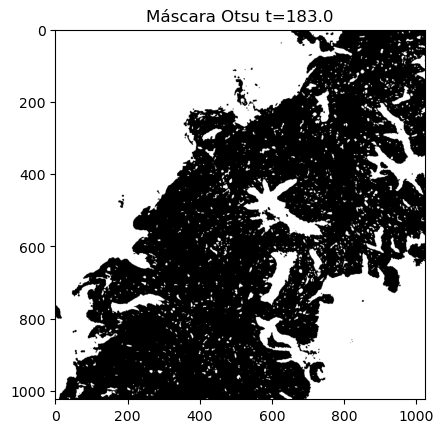

In [6]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

from cv2 import GaussianBlur

def zone_extraction(img_path):
    image = io.imread(img_path)

    plt.title("Imagen original")
    plt.imshow(image)
    plt.show()

    image_uint8 = (image).astype('uint8')

    img = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)

    gauss = GaussianBlur(img, (5, 5), 0)

    plt.title('Filtro Gaussiano')
    plt.imshow(gauss, cmap='gray')
    plt.show()

    t, mask = cv2.threshold(gauss, 0, 1,cv2.THRESH_OTSU)
    #Se convierte a boleano
    mask = mask == 1

    plt.title('Máscara Otsu t=' + str(t))
    plt.imshow(mask, cmap='gray')
    plt.show()

    return mask, img

mask, img = zone_extraction("imgs/histo_1.jpg")


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

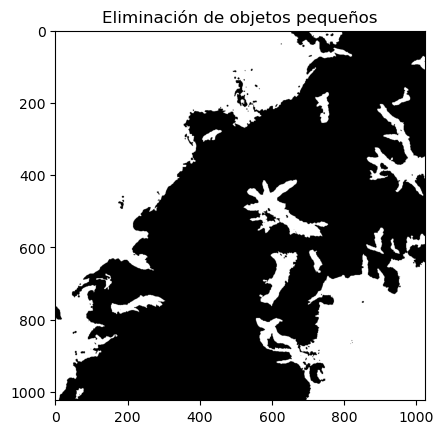

In [102]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

from skimage import morphology


mask_small = morphology.remove_small_objects(mask, 300)

#Aplicamos la máscara a la imagen
plt.title("Eliminación de objetos pequeños")
plt.imshow(mask_small, cmap="gray")
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

Semillas encontradas en [(67, 1003), (228, 757), (143, 696), (855, 852), (621, 678), (721, 637), (938, 600), (996, 586), (892, 584), (622, 501), (432, 290), (950, 351), (743, 212), (962, 188), (1010, 89), (753, 13), (241, 302)]


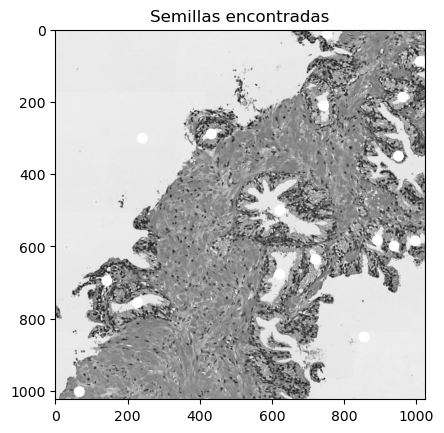

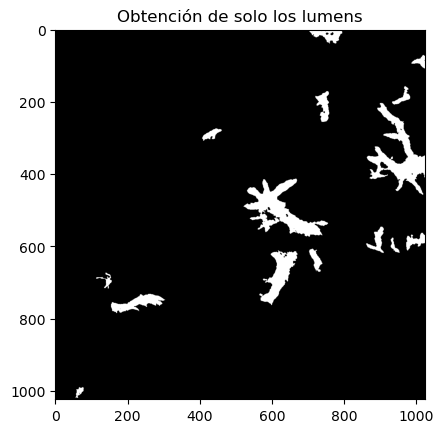

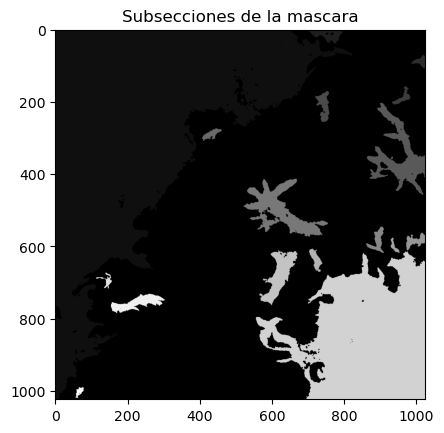

In [103]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.
from skimage import measure
import numpy as np

def find_seeds(mask):

    labeled, num_features = measure.label(mask, return_num=True)
    labeled = cv2.convertScaleAbs(labeled)

    seeds = []
    contours, _ = cv2.findContours(labeled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] > 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            seeds.append((cx, cy))
    return seeds, labeled

def apply_flood_fill(img, seeds):

    h, w = img.shape
    ref = np.zeros((h+2, w+2), np.uint8)

    img_copy = img.copy()

    seeds = [(0, 0),(1000, 1000)]

    for seed in seeds:
        cv2.floodFill(img_copy, None, seed, 0)

    # cv2.floodFill(img_copy, None, (0, 0), 255)

    img_copy = cv2.bitwise_not(img_copy)

    return img_copy

seeds, labeled = find_seeds(mask_small)

new_mask = apply_flood_fill(mask_small *255, seeds)
new_mask = cv2.bitwise_not(new_mask)

img_copy = img.copy()

for seed in seeds:
    cv2.circle(img_copy, tuple(seed) , 5, 255, thickness=20)

print("Semillas encontradas en", seeds)
plt.title("Semillas encontradas")
plt.imshow(img_copy, cmap="gray")
plt.show()

plt.title("Obtención de solo los lumens")
plt.imshow(new_mask, cmap="gray")
plt.show()

plt.title("Subsecciones de la mascara")
plt.imshow(labeled, cmap="gray")
plt.show()



#### 5) Rellenar los objetos de los lúmenes

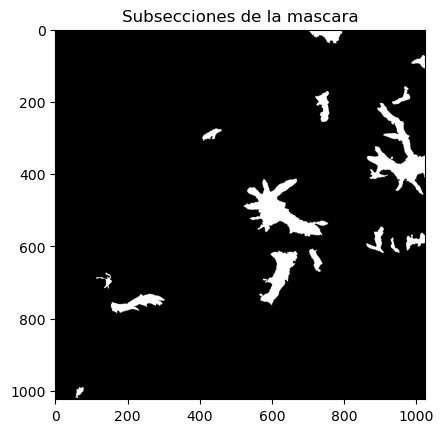

In [104]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante
import scipy as sp

mask_no_holes = sp.ndimage.binary_fill_holes(new_mask)

plt.title("Subsecciones de la mascara")
plt.imshow(mask_no_holes, cmap="gray")
plt.show()


#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

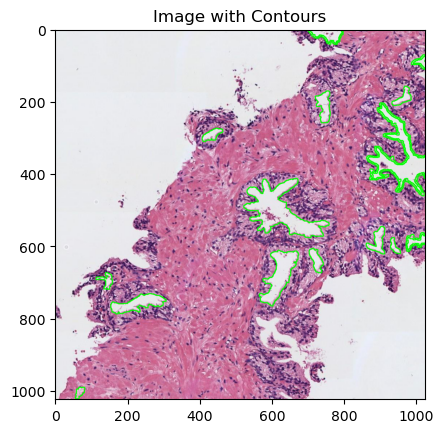

In [108]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

mask_no_holes_u = (mask_no_holes * 255).astype("uint8")


canny = cv2.Canny(mask_no_holes_u, 255/3, 255)
kernel = np.ones((2,2), 'uint8')
canny = cv2.dilate(canny, kernel, iterations=3)

#Mejoramos la calidad de los bordes


contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_with_contours = cv2.drawContours(image_uint8.copy(), contours, -1, (0, 255, 0), 2)

plt.imshow(image_with_contours)
plt.title('Image with Contours')
plt.show()

#### 7) Identificar y cropear el lumen más grande

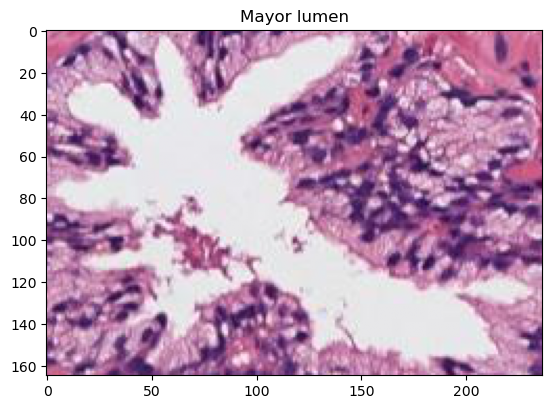

In [111]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

#Se identifica el lumen más grande
largest_contour = max(contours, key=cv2.contourArea)

#Se realiza un crop rectangular de este para tener un contexto de la imagen

x, y, w, h = cv2.boundingRect(largest_contour)

cropped_lumen = image[y:y+h, x:x+w]
cropped_mask = mask_no_holes_u[y:y+h, x:x+w]

plt.imshow(cropped_lumen)
plt.title("Mayor lumen")
plt.show()


#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [113]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad


area = cv2.contourArea(largest_contour)

# Calculate bounding box area
bounding_box_area = w * h

# Calculate convex hull and convex area
hull = cv2.convexHull(largest_contour)
convex_area = cv2.contourArea(hull)

# Calculate eccentricity, major axis length, minor axis length, orientation, and solidity using regionprops
labeled_mask = measure.label(cropped_mask)
props = measure.regionprops(labeled_mask)

# Find the properties of the largest region
largest_region = max(props, key=lambda r: r.area)

eccentricity = largest_region.eccentricity
major_axis_length = largest_region.major_axis_length
minor_axis_length = largest_region.minor_axis_length
orientation = largest_region.orientation
solidity = largest_region.solidity

# Calculate equivalent diameter
equivalent_diameter = np.sqrt(4 * area / np.pi)

# Calculate extent
extent = area / bounding_box_area

# Calculate Feret diameter (maximum distance between any two points on the contour)
feret_diameter = max([np.linalg.norm(p1 - p2) for p1 in largest_contour for p2 in largest_contour])

# Calculate perimeter
perimeter = cv2.arcLength(largest_contour, True)

# Calculate compactness
compactness = (perimeter ** 2) / (4 * np.pi * area)

# Print the results rounded to the fourth decimal place
print(f"Area: {area:.4f}")
print(f"Bounding Box Area: {bounding_box_area:.4f}")
print(f"Convex Area: {convex_area:.4f}")
print(f"Eccentricity: {eccentricity:.4f}")
print(f"Equivalent Diameter: {equivalent_diameter:.4f}")
print(f"Extent: {extent:.4f}")
print(f"Feret Diameter: {feret_diameter:.4f}")
print(f"Major Axis Length: {major_axis_length:.4f}")
print(f"Minor Axis Length: {minor_axis_length:.4f}")
print(f"Orientation: {orientation:.4f}")
print(f"Perimeter: {perimeter:.4f}")
print(f"Solidity: {solidity:.4f}")
print(f"Compactness: {compactness:.4f}")

Area: 15535.0000
Bounding Box Area: 39105.0000
Convex Area: 28602.0000
Eccentricity: 0.8445
Equivalent Diameter: 140.6406
Extent: 0.3973
Feret Diameter: 246.4650
Major Axis Length: 231.6881
Minor Axis Length: 124.0865
Orientation: 0.9970
Perimeter: 1117.6022
Solidity: 0.4872
Compactness: 6.3981
